In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import json
from tqdm import tqdm
import pandas as pd

import os
import sys
sys.path.append('..')
from utils import nethook
from utils import model_utils

## Load Model

In [3]:
MODEL_NAME = "gpt2-medium"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=False)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [4]:
prompt = [
    "Apple has recently released their iPhone 14 line of",
    "Goole has released Pixel 7",
    "I am taking a Machine Learning class",
    "Eiffel Tower is in Paris."
]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = False,
    max_out_len= 50,
    # debug=True,
    get_answer_tokens=True,
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

Apple has recently released their iPhone 14 line of
Apple has recently released their iPhone 14 line of smartphones, and while they've had some issues with the battery, they've been able to fix them.  In fact, they've even managed to fix the issue of the iPhone battery dying in the
p(answer):  p(' devices'[4410])=0.2049, p(' phones'[9512])=0.1882, p(' smartphones'[18151])=0.1707, p(' hands'[2832])=0.0887, p(' products'[3186])=0.0367

Goole has released Pixel 7
Goole has released Pixel 7.0.0. It is the first time Google has released a software update for its flagship handset in over a year. The update comes in at 4.5GB and includes a fix for an issue which caused
p(answer):  p(' and'[290])=0.1817, p(','[11])=0.0804, p('.'[13])=0.0659, p(' Plus'[8227])=0.0247, p(' on'[319])=0.0194

I am taking a Machine Learning class
I am taking a Machine Learning class. I am taking a class that is about Artificial Neural Networks and I am taking a class that is about Neural Networks. The course is call

## Dataloader (the `GoEmotions` dataset)

In [5]:
df = pd.read_csv("../Data/IMDB_50K_Reviews/archive/IMDB Dataset.csv")
df = df.sample(frac = 1)
df.head()

,review,sentiment
3234,You're waiting to see if the remake is better ...,positive
11896,H.G. Wells in 1936 was past his prime and the ...,positive
12219,It seems that Salvatores couldn't decide what ...,negative
27402,"One of the major aspects of ""Malenkaya Vera"" (...",positive
25995,remember back when this movie was made by robe...,positive


In [6]:
for index, row in df.iterrows():
    print(row["review"])
    print(row["sentiment"])
    break

You're waiting to see if the remake is better or worse. I rated the Audie Murphy movie a 3 (I'm a harsh grader), the second lowest I ever gave Audie (the worst being "Battle at Bloody Beach" if you're curious). I give this movie a rating of "8" (and I'm a harsh grader) It's the Civil War story of renegade "soldiers", if you want to call them that, against the North. People like Quantrell, and the men who rode with these outlaws.<br /><br />The original was a watery version, very clean cut, while still depicting the horror of what these men did. Actually, movies such as the older version are best viewed by mature audiences, who can discern the story. I would be more apt to rate the original "R" and this one, with it's gruff nature, a GP, because the newer movie gives a very honest version, a message more easily deciphered by a juvenile than the older version.<br /><br />Film makers since the early sixties have boasted about "Realism", but few of them deliver. Instead, they just give the

In [7]:
train_df = df[0:30000]
validation_df = df[30000:40000]
test_df = df[40000:50000]

In [8]:
train_df.shape, validation_df.shape, test_df.shape

((30000, 2), (10000, 2), (10000, 2))

In [9]:
from torch.utils.data import DataLoader, Dataset

import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|/.*/')

def cleanhtml(raw_html):
  raw_html = raw_html.replace("\\", "")
  raw_html = raw_html.replace("&#039;", "\'")
  cleantext = re.sub(CLEANR, ' ', raw_html)
  split = cleantext.strip().split(" ")
  if(split[0].isnumeric()):
    split = split[1:]
  return " ".join([w for w in split if len(w.strip()) > 0])

# cleanhtml("Don&#039;t mess with me")
# cleanhtml('<a href="#p79290593" class="quotelink">&gt;&gt;79290593</a><br><span class="quote">&gt;canada</span><br><br>and you faggots think we&#039;re the worst shit posters')

class GoEmotions(Dataset):
    def __init__(self, data_frame):
        self.x = []
        self.y = []

        for index, row in data_frame.iterrows():
            self.x.append("<REVIEW>: " + cleanhtml(row["review"]) + " <SENTIMENT>")
            self.y.append(" " + row["sentiment"])
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [10]:
training_dataset = GoEmotions(train_df)
validation_dataset = GoEmotions(validation_df)
test_dataset = GoEmotions(test_df)

len(training_dataset), len(validation_dataset), len(test_dataset)

(30000, 10000, 10000)

In [11]:
batch_size = 2

training_dataloader = DataLoader(training_dataset, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Tuning

In [12]:
embedder = "transformer.wte"
layer_norm_final = "transformer.ln_f"
unembedder = "lm_head"

In [13]:
num_epochs = 3

learning_rate = 5e-4
warmup_steps = 200
weight_decay = 0

optimization_batch_size = 8
max_token_per_comment = 963

save_path = f"../Saved_weights/Fine-Tuned_CLF__IMDB_50K/{MODEL_NAME}"

In [14]:
tokenizer.unk_token_id

50256

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

tunable_weights = {
    n: p
    for n, p in model.named_parameters()
    if n.startswith("transformer.h.")       # only tune the layers, leave the embedding and unembedding alone
}
# print(f"Weights to be updated: {list(tunable_weights.keys())}")

for name, w in model.named_parameters():
    w.requires_grad = name in tunable_weights

# optimizer = AdamW(
#     # model.parameters(),
#     [v for _, v in tunable_weights.items()],
#     lr = learning_rate,
# )
# scheduler = get_linear_schedule_with_warmup(
#     optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
# )

optimizer = torch.optim.Adam(
    [v for _, v in tunable_weights.items()],
    lr=learning_rate,
    weight_decay=weight_decay,
)

num_prompts_optimized = 0
training_loss_track = []
validation_loss_track = []

target_track = {
    " positive": 0,
    " negative": 0
}


for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    for reviews, sentiments in tqdm(training_dataloader):
        tokenized_inputs = tokenizer(
            list(reviews),
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)

        if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
            # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
            continue
            
        for t in sentiments:
            target_track[t] += 1

        target_ids = tokenizer(
            list(sentiments), 
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)['input_ids']

        # print(sentiments)

        # print(tokenized_inputs['input_ids'].shape)
        # print(sentiments, target_ids)

        last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1) - 1
        loss_mask = target_ids != tokenizer.unk_token_id

        # print(last_token_inds)
        # print(loss_mask)

        # with nethook.TraceDict(
        #     model,
        #     [embedder, layer_norm_final, unembedder],
        # ) as traces:
        outputs = model(
            **tokenized_inputs, 
        )

        probs = torch.nn.functional.log_softmax(
            outputs.logits[torch.arange(batch_size), last_token_inds], dim=-1
        )
        # print(probs)

        loss = -(torch.gather(probs, 1, target_ids) * loss_mask).sum(1) / loss_mask.sum(1)
        loss = loss.mean()

        training_loss_track.append(loss.item())

        # print(loss)
        # break

        model.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # num_prompts_optimized += batch_size
        # if(True or num_prompts_optimized % optimization_batch_size):
        #     training_loss_track.append(loss.item())

        #     optimizer.step()
        #     scheduler.step()
            
        #     optimizer.zero_grad()
        #     model.zero_grad()
        # break
    # break

Epoch 1


100%|██████████| 15000/15000 [36:37<00:00,  6.83it/s]


Epoch 2


100%|██████████| 15000/15000 [36:38<00:00,  6.82it/s]


Epoch 3


100%|██████████| 15000/15000 [37:19<00:00,  6.70it/s]


In [16]:
print("#####################  CHECKPOINT -- saving weights #####################")
os.makedirs(save_path, exist_ok = True)
torch.save(model.state_dict(), f"{save_path}/finetuned_{num_prompts_optimized}.pth")
with open(f"{save_path}/loss_track_{num_prompts_optimized}.json", "w") as f:
    json.dump({"training": training_loss_track, "validation": validation_loss_track}, f)

#####################  CHECKPOINT -- saving weights #####################


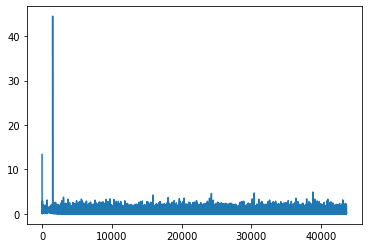

In [17]:
import matplotlib.pyplot as plt

plt.plot(training_loss_track)

## Testing

In [25]:
checkpoint = torch.load('../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned_0.pth')
print("loaded checkpoint")
model.load_state_dict(checkpoint)
print("loaded model weights")

loaded checkpoint
loaded model weights


In [28]:
prompt = [
    "This was an awesome movie",
    "This was a bad movie",
    "This movie is gross"
]

prompt = ["<REVIEW>: " + p + " <SENTIMENT>" for p in prompt]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = True,
    max_out_len= 20,
    # debug=True,
    get_answer_tokens=True,
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

<REVIEW>: This was an awesome movie <SENTIMENT>
<REVIEW>: This was an awesome movie <SENTIMENT> positive negative negative negative positive
p(answer):  p(' positive'[3967])=0.9482, p(' negative'[4633])=0.0517, p(' Positive'[33733])=0.0, p(' positives'[38548])=0.0, p('positive'[24561])=0.0

<REVIEW>: This was a bad movie <SENTIMENT>
<REVIEW>: This was a bad movie <SENTIMENT> negative positive positive positive positive
p(answer):  p(' negative'[4633])=0.8058, p(' positive'[3967])=0.1941, p(' Negative'[36183])=0.0, p(' Positive'[33733])=0.0, p(' positives'[38548])=0.0

<REVIEW>: This movie is gross <SENTIMENT>
<REVIEW>: This movie is gross <SENTIMENT> negative positive positive positive positive positive
p(answer):  p(' negative'[4633])=0.5934, p(' positive'[3967])=0.4065, p(' Positive'[33733])=0.0, p(' Negative'[36183])=0.0, p(' positives'[38548])=0.0



In [21]:
testing_dataloader = DataLoader(test_dataset, batch_size=5)

target = []
predict = []

for reviews, sentiment in tqdm(testing_dataloader):
    tokenized_inputs = tokenizer(
        list(reviews),
        padding = True,
        return_tensors="pt"
    ).to(next(model.parameters()).device)

    if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
        # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
        continue

    last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1)
    max_out_len = max(last_token_inds).item()

    with torch.no_grad():
        txt, ret_dict = model_utils.generate_fast(
            model, tokenizer,
            list(reviews),
            argmax_greedy = True,
            max_out_len= max_out_len + 3,
            # debug=True,
            get_answer_tokens=True,
        )

    for t, p in zip(list(sentiment), ret_dict['answer']):
        target.append(t)
        predict.append(p['top_token'])

    # break

100%|██████████| 2000/2000 [2:03:28<00:00,  3.70s/it]  


In [22]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(target, predict).ravel()

print(tp, fp)
print(fn, tn)

4123 855
431 3891


In [24]:
sensitivity = tp/(tp + fn)
specificity = tn/(tn + fp)
balanced_acc = (sensitivity + specificity)/2

balanced_acc

0.8626031101983391